In [1]:
import pandas as pd

price_df = pd.read_csv("MHRprice_chart.csv")
players_df = pd.read_csv("MHRplayers_chart.csv")

price_df["DateTime"] = pd.to_datetime(price_df["DateTime"])
players_df["DateTime"] = pd.to_datetime(players_df["DateTime"])

price_df.drop(price_df.columns[2], axis=1, inplace=True)
players_df.drop(players_df.columns[2], axis=1, inplace=True)

#print(price_df)
#print(players_df)

#set price based on time
merged_df = pd.merge_asof(players_df.sort_values("DateTime"), price_df.sort_values("DateTime"), on="DateTime", direction="backward")

#print(merged_df)

merged_df = merged_df.dropna()

merged_df = merged_df[merged_df['Final price'] != 0]

merged_df.to_csv("MHRmerged_table.csv", index=False)

In [2]:
highest_value = merged_df["Final price"].max()
merged_df["Discount"] = (highest_value - merged_df["Final price"]) / highest_value

merged_df['DateTime'] = pd.to_datetime(merged_df['DateTime'])
merged_df['Time Since Release'] = (merged_df['DateTime'] - merged_df['DateTime'].iloc[0]).dt.total_seconds()

print(merged_df)
merged_df.to_csv("MHRmerged_table.csv", index=False)

                DateTime  Players  Final price  Discount  Time Since Release
0    2022-01-12 00:00:00    90773        59.99  0.000000                 0.0
1    2022-01-13 00:00:00    99076        59.99  0.000000             86400.0
2    2022-01-14 00:00:00   109341        59.99  0.000000            172800.0
3    2022-01-15 00:00:00   130427        59.99  0.000000            259200.0
4    2022-01-16 00:00:00   134262        59.99  0.000000            345600.0
...                  ...      ...          ...       ...                 ...
2590 2024-12-08 01:40:00     7334        39.99  0.333389          91676400.0
2591 2024-12-08 01:50:00     7624        39.99  0.333389          91677000.0
2592 2024-12-08 02:00:00     7909        39.99  0.333389          91677600.0
2593 2024-12-08 02:10:00     8200        39.99  0.333389          91678200.0
2594 2024-12-08 02:20:00     8328        39.99  0.333389          91678800.0

[2594 rows x 5 columns]


In [ ]:
import matplotlib.pyplot as plt

merged_df = pd.read_csv("MHRmerged_table.csv")
merged_df["DateTime"] = pd.to_datetime(merged_df["DateTime"])

fig, ax1 = plt.subplots(figsize=(30, 10))

# Plot the Final price on the first y-axis
ax1.plot(merged_df["DateTime"], merged_df["Final price"], color='tab:blue', label="Final price")
ax1.set_xlabel("DateTime")
ax1.set_ylabel("Final price($)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for the Players
ax2 = ax1.twinx()
ax2.plot(merged_df["DateTime"], merged_df["Players"], color='tab:red', label="Players")
ax2.set_ylabel("Players", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Final Price and Players over Time")
plt.show()

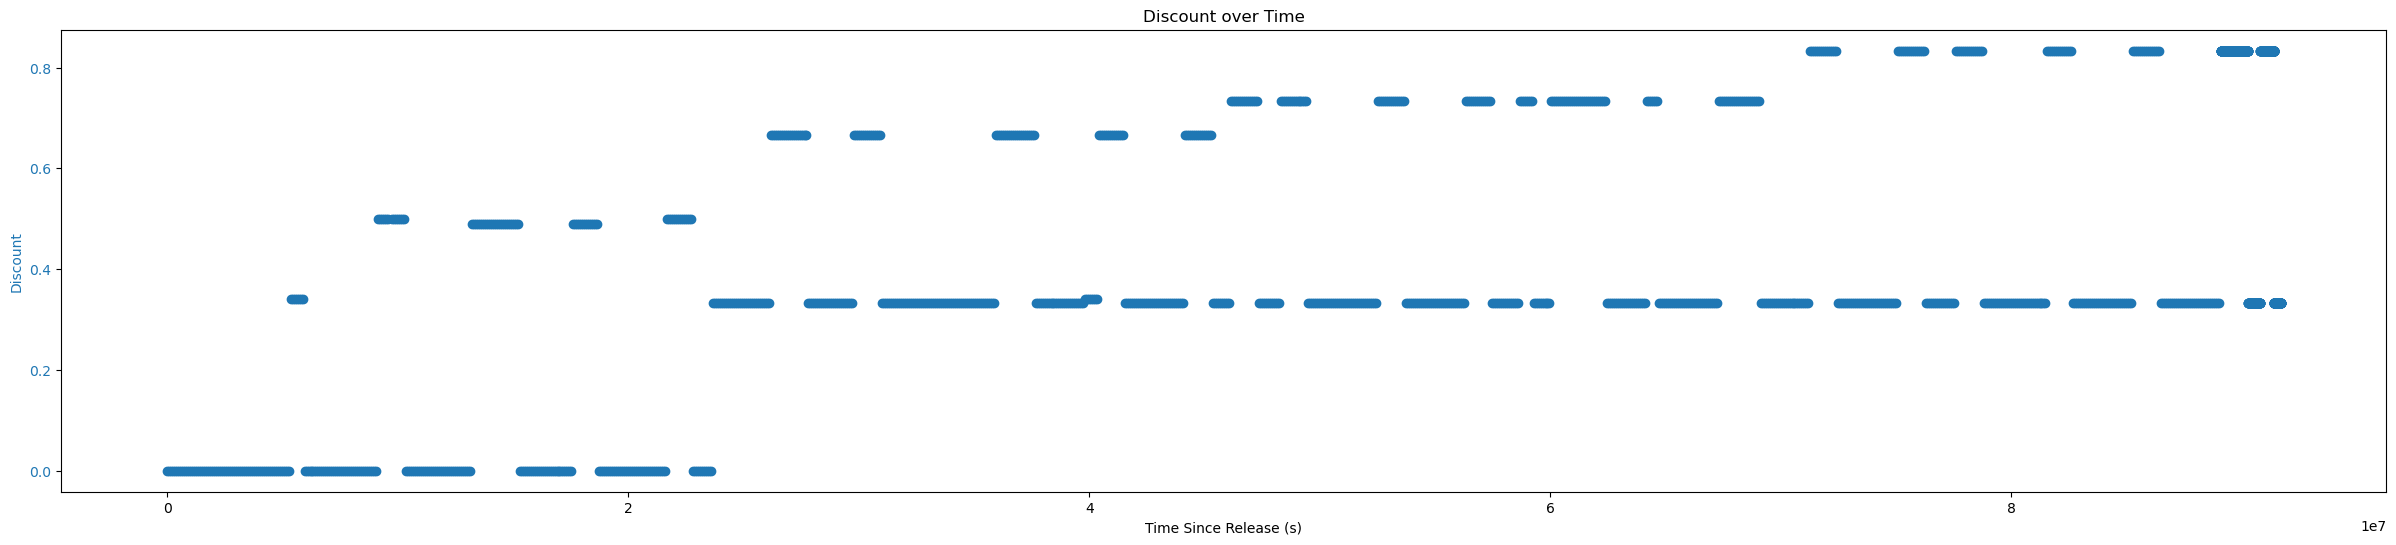

In [4]:
fig, ax = plt.subplots(figsize=(30, 6))

ax.scatter(merged_df['Time Since Release'], merged_df["Discount"], color='tab:blue', label="Discount")
ax.set_xlabel('Time Since Release (s)')
ax.set_ylabel("Discount", color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

plt.title("Discount over Time")
plt.show()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = merged_df[['Time Since Release']].values
y = merged_df['Discount'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depth = 25  #the depth of the tree
tree_regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
tree_regressor.fit(X_train, y_train)

y_pred = tree_regressor.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.00457603991553687
R^2 Score: 0.9388825073931762


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = merged_df[['Final price']].values
y = merged_df['Time Since Release'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depth = 25  #the depth of the tree
tree_regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
tree_regressor.fit(X_train, y_train)

y_pred = tree_regressor.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}\n")

#Predicting the date for a user-inputted price
try:
    desired_price = float(input("Enter the price you want to predict the date for: $"))

    while desired_price > highest_value:
        print("Please Enter a price below the release price, $" + str(merged_df['Final price'].max()) + " for a valid prediction")
        desired_price = float(input("Enter the price you want to predict the date for: $"))
    
    # Predict 'Time Since Release' using the inverse relationship
    time_since_release_pred = tree_regressor.predict([[desired_price]])[0]
    
    # Reference the earliest date in your dataset (assumed as the release date)
    release_date = merged_df["DateTime"].min()
    
    # Calculate the predicted date
    predicted_date = release_date + pd.to_timedelta(time_since_release_pred, unit='s')
    
    print(f"The predicted date for a price of ${desired_price:.2f} is approximately {predicted_date.strftime('%Y-%m-%d')}.")
except ValueError:
    print("Invalid input! Please enter a numerical value for the price.")

Mean Squared Error: 216243322592576.53
R^2 Score: 0.7198353423493578



Enter the price you want to predict the date for: $ 20


The predicted date for a price of $20.00 is approximately 2023-02-21.


In [12]:
desired_price = float(input("Enter the desired price: "))  
release_date = pd.to_datetime('2025/2/28')
release_price = 69.99

# Function to predict date for the desired price for Monster Hunter Wilds
try:
    while desired_price > release_price:
        print("Please Enter a price below the release price for a valid prediction")
        desired_price = float(input("Enter the price you want to predict the date for: $"))

    time_since_release_pred = tree_regressor.predict([[desired_price]])[0]

    predicted_date = release_date + pd.to_timedelta(time_since_release_pred, unit='s')

    print(f"The predicted date of MHWilds for a price of ${desired_price:.2f} is approximately {predicted_date.strftime('%Y-%m-%d')}.")
except ValueError:
    print("Invalid input! Please enter a numerical value for the price.")

Enter the desired price:  20


The predicted date of MHWilds for a price of $20.00 is approximately 2026-04-09.


In [ ]:
#Database component

In [8]:
import sqlite3

def initialize_database():
    conn = sqlite3.connect('MHR_game_analysis.db')
    cursor = conn.cursor()

    # create game table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS games (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        release_date DATE
        )
    ''')

    # create price trend table 
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS PriceTrends(
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            game_id INTEGER NOT NULL,
            datetime DATETIME NOT NULL,
            price REAL NOT NULL,
            FOREIGN KEY (game_id) REFERENCES games (id)
        )
    ''')

    # create player trends table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS PlayerTrends (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            game_id INTEGER NOT NULL,
            datetime DATETIME NOT NULL,
            players INTEGER NOT NULL,
            FOREIGN KEY (game_id) REFERENCES games (id)
        )
    ''')

    print("database 'MHR_game_analysis.db' and tables have been initialized.")
    conn.commit()
    conn.close()

# initialize the database
initialize_database()


database 'MHR_game_analysis.db' and tables have been initialized.


In [9]:
import sqlite3
import pandas as pd

def insert_data_from_merged_csv(game_name, release_date, merged_csv):
    conn = sqlite3.connect('MHR_game_analysis.db', timeout=10)
    cursor = conn.cursor()

    # insert game details into the game table
    cursor.execute('INSERT INTO games (name, release_date) VALUES (?, ?)', (game_name, release_date))
    # get the ID of the newly inserted game
    game_id = cursor.lastrowid

    # load the merged data
    merged_df = pd.read_csv(merged_csv)
    
    # insert price trend data into PriceTrends
    for _, row in merged_df.iterrows():
        cursor.execute('INSERT INTO PriceTrends (game_id, datetime, price) VALUES (?, ?, ?)',
                       (game_id, row["DateTime"], row["Final price"]))
    
    # insert player trend data into PlayerTrends
    for _, row in merged_df.iterrows():
        cursor.execute('INSERT INTO PlayerTrends (game_id, datetime, players) VALUES (?, ?, ?)',
                       (game_id, row["DateTime"], row["Players"]))
    
    conn.commit()
    conn.close()
    print(f"data for '{game_name}' inserted into tables:)")

# insert data for mhr using the merged table
try:
    insert_data_from_merged_csv("Monster Hunter: Rise", "2021-03-26", "MHRmerged_table.csv")
except Exception as e:
    print(f"An error occurred: {e}")


data for 'Monster Hunter: Rise' inserted into tables:)


In [10]:
import sqlite3

def query_game_trends(game_name):
    conn = sqlite3.connect('MHR_game_analysis.db')
    cursor = conn.cursor()

    # get the game id
    cursor.execute('SELECT id FROM games WHERE name = ?', (game_name,))
    game_id = cursor.fetchone()
    if not game_id:
        print(f"Game '{game_name}' not found in the database.")
        conn.close()
        return
    game_id = game_id[0]

    # fetch price trends
    print(f"\nPrice Trends for {game_name} (First 20 Rows):")
    for row in cursor.execute('SELECT datetime, price FROM PriceTrends WHERE game_id = ? LIMIT 20', (game_id,)):
        print(row)

    # fetch player trends
    print(f"\nPlayer Trends for {game_name} (First 20 Rows):")
    for row in cursor.execute('SELECT datetime, players FROM PlayerTrends WHERE game_id = ? LIMIT 20', (game_id,)):
        print(row)

    conn.close()

# query trends for Monster Hunter: Rise
query_game_trends("Monster Hunter: Rise")



Price Trends for Monster Hunter: Rise (First 20 Rows):
('2022-01-12 00:00:00', 59.99)
('2022-01-13 00:00:00', 59.99)
('2022-01-14 00:00:00', 59.99)
('2022-01-15 00:00:00', 59.99)
('2022-01-16 00:00:00', 59.99)
('2022-01-17 00:00:00', 59.99)
('2022-01-18 00:00:00', 59.99)
('2022-01-19 00:00:00', 59.99)
('2022-01-20 00:00:00', 59.99)
('2022-01-21 00:00:00', 59.99)
('2022-01-22 00:00:00', 59.99)
('2022-01-23 00:00:00', 59.99)
('2022-01-24 00:00:00', 59.99)
('2022-01-25 00:00:00', 59.99)
('2022-01-26 00:00:00', 59.99)
('2022-01-27 00:00:00', 59.99)
('2022-01-28 00:00:00', 59.99)
('2022-01-29 00:00:00', 59.99)
('2022-01-30 00:00:00', 59.99)
('2022-01-31 00:00:00', 59.99)

Player Trends for Monster Hunter: Rise (First 20 Rows):
('2022-01-12 00:00:00', 90773)
('2022-01-13 00:00:00', 99076)
('2022-01-14 00:00:00', 109341)
('2022-01-15 00:00:00', 130427)
('2022-01-16 00:00:00', 134262)
('2022-01-17 00:00:00', 114048)
('2022-01-18 00:00:00', 111392)
('2022-01-19 00:00:00', 105767)
('2022-01-20 

In [11]:
import sqlite3

def query_game_trends(game_name):
    conn = sqlite3.connect('MHR_game_analysis.db')
    cursor = conn.cursor()

    # fetch the game id
    cursor.execute('SELECT id FROM games WHERE name = ?', (game_name,))
    game_id = cursor.fetchone()
    if not game_id:
        print(f"Game '{game_name}' not found in the database.")
        conn.close()
        return
    game_id = game_id[0]

    # get price trends (first 20 rows)
    print(f"\nPrice Trends for {game_name} (First 20 Rows):")
    for i, row in enumerate(cursor.execute('SELECT datetime, price FROM PriceTrends WHERE game_id = ?', (game_id,))):
        if i >= 20:
            break
        print(row)

    # get player trends (first 20 rows)
    print(f"\nPlayer Trends for {game_name} (First 20 Rows):")
    for i, row in enumerate(cursor.execute('SELECT datetime, players FROM PlayerTrends WHERE game_id = ?', (game_id,))):
        if i >= 20:
            break
        print(row)

    conn.close()

# query trends for Monster Hunter: Rise
query_game_trends("Monster Hunter: Rise")



Price Trends for Monster Hunter: Rise (First 20 Rows):
('2022-01-12 00:00:00', 59.99)
('2022-01-13 00:00:00', 59.99)
('2022-01-14 00:00:00', 59.99)
('2022-01-15 00:00:00', 59.99)
('2022-01-16 00:00:00', 59.99)
('2022-01-17 00:00:00', 59.99)
('2022-01-18 00:00:00', 59.99)
('2022-01-19 00:00:00', 59.99)
('2022-01-20 00:00:00', 59.99)
('2022-01-21 00:00:00', 59.99)
('2022-01-22 00:00:00', 59.99)
('2022-01-23 00:00:00', 59.99)
('2022-01-24 00:00:00', 59.99)
('2022-01-25 00:00:00', 59.99)
('2022-01-26 00:00:00', 59.99)
('2022-01-27 00:00:00', 59.99)
('2022-01-28 00:00:00', 59.99)
('2022-01-29 00:00:00', 59.99)
('2022-01-30 00:00:00', 59.99)
('2022-01-31 00:00:00', 59.99)

Player Trends for Monster Hunter: Rise (First 20 Rows):
('2022-01-12 00:00:00', 90773)
('2022-01-13 00:00:00', 99076)
('2022-01-14 00:00:00', 109341)
('2022-01-15 00:00:00', 130427)
('2022-01-16 00:00:00', 134262)
('2022-01-17 00:00:00', 114048)
('2022-01-18 00:00:00', 111392)
('2022-01-19 00:00:00', 105767)
('2022-01-20 